In [1]:
# Install a pip package in the current Jupyter kernel
import subprocess
subprocess.call([sys.executable,"-m","pip","install","numpy","gspread","oauth2client","df2gspread","pandas","matplotlib","seaborn"])

0

In [2]:
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_string_dtype
import gspread
import seaborn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
import numpy as np
from itertools import chain
from oauth2client.service_account import ServiceAccountCredentials
import time

In [3]:
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 6000)
pd.set_option('display.width', 6000)
pd.options.display.max_colwidth = 0

In [4]:
data = pd.read_csv("../second_run/raw_results.csv")
dcData = pd.read_csv("../second_run/filtered_dc.csv")

def convertLikert(df):
    likertMap = {"Strongly Disagree": 1, "Disagree": 2, "Neutral": 3, "Agree": 4, "Strongly Agree": 5}
    df[likertColumns] = df[likertColumns].replace(likertMap)
    
likertColumns = list(data[data.columns[data.isin(["Strongly Disagree","Disagree","Neutral","Agree","Strongly Agree"]).all()]].columns)

data["Timestamp"] = pd.to_datetime(data["Timestamp"],infer_datetime_format=True)

convertLikert(data)

commaSeparatedColumns = ["Where do you currently work?","What are your main professional responsibilities?"]

data[commaSeparatedColumns] = data[commaSeparatedColumns].stack().map(lambda value: value.split(",")).unstack()

#data = data[data["... where you created/updated a docker-compose.yml file?"] != 0]
data = data[data["... where you created/updated a Dockerfile?"] != 0]
originalData = data.copy()

threshold = 3

dataInexperienced = data[data["... where you created/updated a Dockerfile?"] <= 3]
dataExperienced = data[data["... where you created/updated a Dockerfile?"] > 3]
dcDataInexperienced = dcData[dcData["... where you created/updated a docker-compose.yml file?"] < 3]
dcDataExperienced = dcData[dcData["... where you created/updated a docker-compose.yml file?"] >= 3]
print(dataInexperienced.shape)
print(dataExperienced.shape)
print(dcDataInexperienced.shape)
print(dcDataExperienced.shape)

(65, 41)
(54, 41)
(48, 26)
(59, 26)


In [5]:
def toLong(inputData):
    inputData.reset_index()
    inputData["id"] = inputData.index

    inputData = inputData.add_prefix('value')
    inputData.rename(columns={'valueid': 'id'}, inplace=True)
    inputData.rename(columns={'valuegroup': 'group'}, inplace=True)

    inputData = pd.wide_to_long(inputData,stubnames="value",i=["id"],j="params",suffix='.+')
    inputData.reset_index(inplace=True)
    inputData = inputData.explode('value')
    
    return inputData

data = toLong(data)
dcData = toLong(dcData)
dataInexperienced = toLong(dataInexperienced)
dcDataInexperienced = toLong(dcDataInexperienced)
dataExperienced = toLong(dataExperienced)
dcDataExperienced = toLong(dcDataExperienced)

In [6]:
#https://stackoverflow.com/a/51535326/6391820
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            value = '{:.0f}'.format(p.get_width())
            _x = p.get_x() + p.get_width() + 0.2
            _y = p.get_y() + p.get_height() - 0.30
            ax.text(_x, _y, value, ha="left", color="black") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

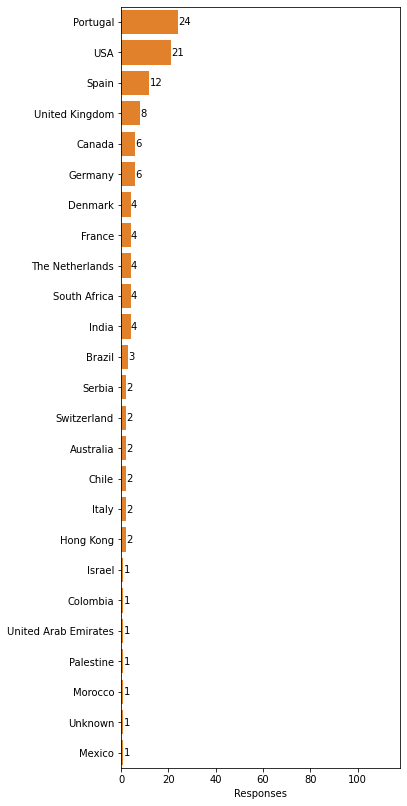

In [7]:
plt.figure(figsize=(5,14))
occurences = pd.DataFrame(data[data["params"]=="Country"]['value'].str.strip().value_counts())
occurences.reset_index(inplace=True)
occurences.rename(columns={'index':'responses', 'value': 'count'}, inplace=True)
ax = seaborn.barplot(x="count", y="responses", data=occurences, color="C1")
ax.set(yticklabels=[textwrap.fill(e, 24) for e in occurences['responses'].unique()],ylabel='', xlabel='Responses', xlim=[0,118])
show_values_on_bars(ax)
plt.savefig('countries.pdf', format='pdf', bbox_inches='tight')
plt.show()

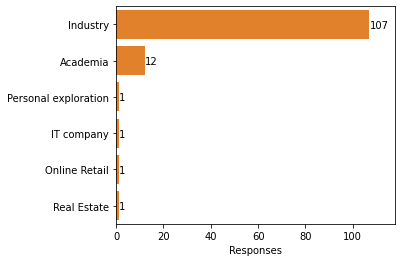

In [8]:
plt.figure(figsize=(5,4))
occurences = pd.DataFrame(data[data["params"]=="Where do you currently work?"]['value'].str.strip().value_counts())
occurences.reset_index(inplace=True)
occurences.rename(columns={'index':'responses', 'value': 'count'}, inplace=True)
ax = seaborn.barplot(x="count", y="responses", data=occurences, color="C1")
ax.set(yticklabels=[textwrap.fill(e, 24) for e in occurences['responses'].unique()],ylabel='', xlabel='Responses', xlim=[0,118])
show_values_on_bars(ax)
plt.savefig('industries.pdf', format='pdf', bbox_inches='tight')
plt.show()

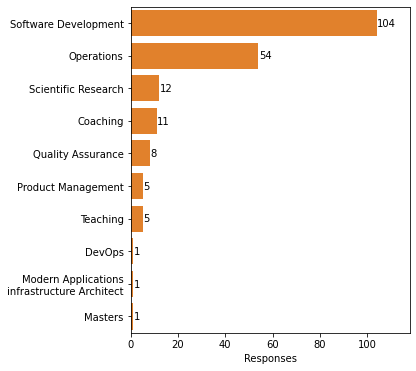

In [9]:
plt.figure(figsize=(5,6))
occurences = pd.DataFrame(data[data["params"]=="What are your main professional responsibilities?"]['value'].str.strip().value_counts())
occurences.reset_index(inplace=True)
occurences.rename(columns={'index':'responses', 'value': 'count'}, inplace=True)
ax = seaborn.barplot(x="count", y="responses", data=occurences, color="C1")
ax.set(yticklabels=[textwrap.fill(e, 24) for e in occurences['responses'].unique()],ylabel='', xlabel='Responses', xlim=[0,118])
show_values_on_bars(ax)
plt.savefig('profResponsibilities.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [10]:
def renderGraph(inputData):
    param1 = 'When I write a Dockerfile, I spend considerable time ... [reading Docker documentation.]'
    param2 = 'When I write a Dockerfile, I spend considerable time ... [finding out what are the right Dockerfile commands that I need.]'
    param3 = 'When I write a Dockerfile, I spend considerable time ... [finding out what parent image is the most suitable.]'
    param4 = 'When I write a Dockerfile, I spend considerable time ... [finding out what are the dependencies of my system that must be added to the docker image.]'
    param5 = 'When I write a Dockerfile, I spend considerable time ... [confirming if the resulting container is working as intended.]'
    param6 = 'When I write a Dockerfile, I spend considerable time ... [trying to understand why the resulting container is not working as intended (e.g., running commands and tests on the container).]'
    param7 = 'When I write a Dockerfile, I spend considerable time ... [finding out which commands are responsible for the container misbehaviour.]'
    param8 = 'When I write a Dockerfile, I spend considerable time ... [rebuilding the image and re-running the container to confirm that it is working as intended.]'

    mask = ((inputData["params"] == param1) | (inputData["params"] == param2) | (inputData["params"] == param3) | (inputData["params"] == param4) \
            | (inputData["params"] == param5) | (inputData["params"] == param6) | (inputData["params"] == param7) | (inputData["params"] == param8))

    dataset = inputData[mask]

    if len(dataset[dataset['value'] < 6]) > 0:
        ax1 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 6], color="C2")
    if len(dataset[dataset['value'] < 5]) > 0:
        ax2 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 5], color="C8")
    if len(dataset[dataset['value'] < 4]) > 0:
        ax3 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 4], color="C7")
    if len(dataset[dataset['value'] < 3]) > 0:
        ax4 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 3], color="C1")
    if len(dataset[dataset['value'] < 2]) > 0:
        ax5 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 2], color="C3")

    seaborn.countplot(x="params", data=dataset[dataset['value'] < 6], alpha=0)
    ax5.set(xlabel='Activities', ylabel='Responses', xticklabels=["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"])
    strg_agree = mpatches.Patch(facecolor='C2', label='Strongly Agree')
    agree = mpatches.Patch(facecolor='C8', label='Agree')
    neutral = mpatches.Patch(facecolor='C7', label='Neutral')
    disagree = mpatches.Patch(facecolor='C1', label='Disagree')
    strg_disagree = mpatches.Patch(facecolor='C3', label='Strongly Disagree')
    plt.legend(handles=[strg_agree,agree,neutral,disagree,strg_disagree], bbox_to_anchor=(1, 1))
    return ax5

In [11]:
def renderDCGraph(inputData):
    param1 = 'When I write a docker-compose.yml file, I spend considerable time… [reading Docker documentation.]'
    param2 = 'When I write a docker-compose.yml file, I spend considerable time… [finding out what are the keys that I need.]'
    param3 = 'When I write a docker-compose.yml file, I spend considerable time… [finding out what images are available.]'
    param4 = 'When I write a docker-compose.yml file, I spend considerable time… [trying to understand why the services are not working as intended.]'
    param5 = 'When I write a docker-compose.yml file, I spend considerable time… [(re)starting the services to confirm that they are working as intended.]'
    param6 = 'When I write a docker-compose.yml file, I spend considerable time… [configuring the properties of each service (e.g. port mapping, name, ...).]'
    param7 = 'When I write a docker-compose.yml file, I spend considerable time… [configuring the dependencies between the services (e.g. depends_on).]'
    param8 = 'When I write a docker-compose.yml file, I spend considerable time… [configuring volumes and how they are attached to the services.]'
    param9 = 'When I write a docker-compose.yml file, I spend considerable time… [configuring networks and how they are connected to the services.]'
    param10 = 'When I write a docker-compose.yml file, I spend considerable time… [configuring configs and how they are accessed by the services.]'
    param11 = 'When I write a docker-compose.yml file, I spend considerable time… [configuring secrets and how they are accessed by the services.]'
    param12 = 'When I read a docker-compose.yml file, I spend considerable time trying to understand … [ what the services are.]'
    param13 = 'When I read a docker-compose.yml file, I spend considerable time trying to understand … [the dependencies between services (e.g. depends_on).]'
    param14 = 'When I read a docker-compose.yml file, I spend considerable time trying to understand … [what volumes are used and how they are attached to the services.]'
    param15 = 'When I read a docker-compose.yml file, I spend considerable time trying to understand … [what networks are used and how they are connected to the services.]'
    
#     mask = ((inputData["params"] == param1) | (inputData["params"] == param2) | (inputData["params"] == param3) | (inputData["params"] == param4) \
#             | (inputData["params"] == param5) | (inputData["params"] == param6) | (inputData["params"] == param7) | (inputData["params"] == param8) \
#             | (inputData["params"] == param9) | (inputData["params"] == param10) | (inputData["params"] == param11))
   
    mask = ((inputData["params"] == param1) | (inputData["params"] == param2) | (inputData["params"] == param3) | (inputData["params"] == param4) \
             | (inputData["params"] == param5) | (inputData["params"] == param6) | (inputData["params"] == param7) | (inputData["params"] == param8) \
             | (inputData["params"] == param9) | (inputData["params"] == param10) | (inputData["params"] == param11) | (inputData["params"] == param12) \
             | (inputData["params"] == param13) | (inputData["params"] == param14) | (inputData["params"] == param15))
    
    dataset = inputData[mask]

    if len(dataset[dataset['value'] < 6]) > 0:
        ax1 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 6], color="C2")
    if len(dataset[dataset['value'] < 5]) > 0:
        ax2 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 5], color="C8")
    if len(dataset[dataset['value'] < 4]) > 0:
        ax3 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 4], color="C7")
    if len(dataset[dataset['value'] < 3]) > 0:
        ax4 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 3], color="C1")
    if len(dataset[dataset['value'] < 2]) > 0:
        ax5 = seaborn.countplot(x="params", data=dataset[dataset['value'] < 2], color="C3")

    seaborn.countplot(x="params", data=dataset[dataset['value'] < 6], alpha=0)
    ax5.set(xlabel='Activities', ylabel='Responses', xticklabels=["W1", "W2", "W3", "W4", "W5", "W6", "W7", "W8", "W9", "W10", "W11", "R1", "R2", "R3", "R4"])
    strg_agree = mpatches.Patch(facecolor='C2', label='Strongly Agree')
    agree = mpatches.Patch(facecolor='C8', label='Agree')
    neutral = mpatches.Patch(facecolor='C7', label='Neutral')
    disagree = mpatches.Patch(facecolor='C1', label='Disagree')
    strg_disagree = mpatches.Patch(facecolor='C3', label='Strongly Disagree')
    plt.legend(handles=[strg_agree,agree,neutral,disagree,strg_disagree], bbox_to_anchor=(1, 1))
    return ax5

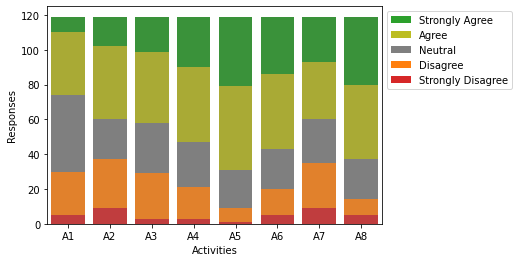

In [12]:
renderGraph(data)
plt.savefig('D_Activities.pdf', format='pdf', bbox_inches='tight')

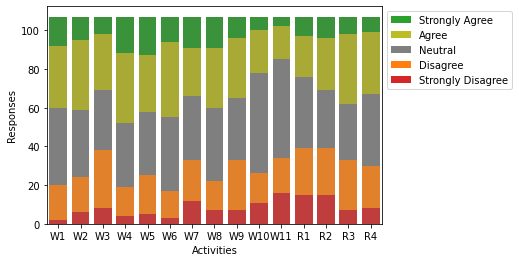

In [13]:
renderDCGraph(dcData)
plt.savefig('DC_Activities.pdf', format='pdf', bbox_inches='tight')

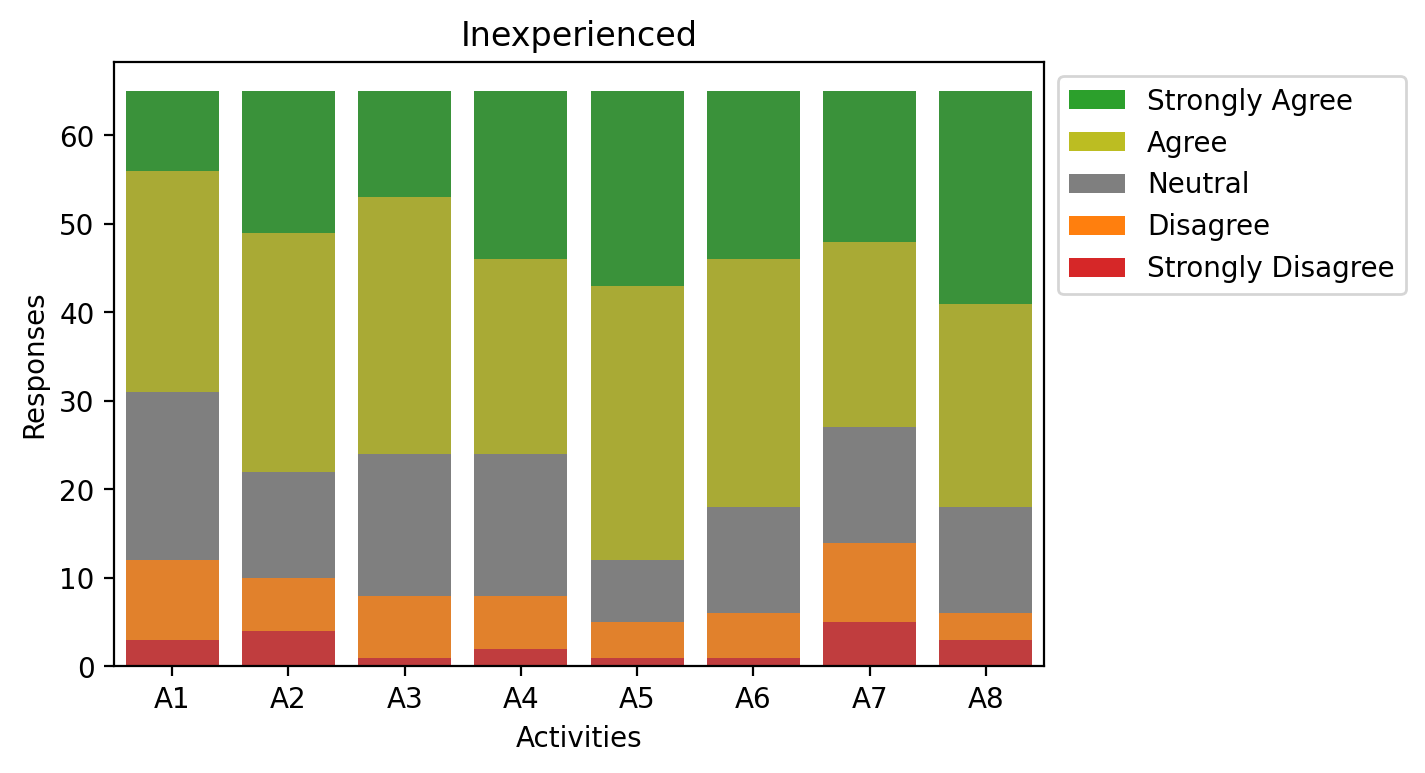

In [14]:
plt.figure(dpi=200)
ax = renderGraph(dataInexperienced)
ax.set(title="Inexperienced")
plt.savefig('D_Activities_Inexperienced.pdf', format='pdf', bbox_inches='tight')

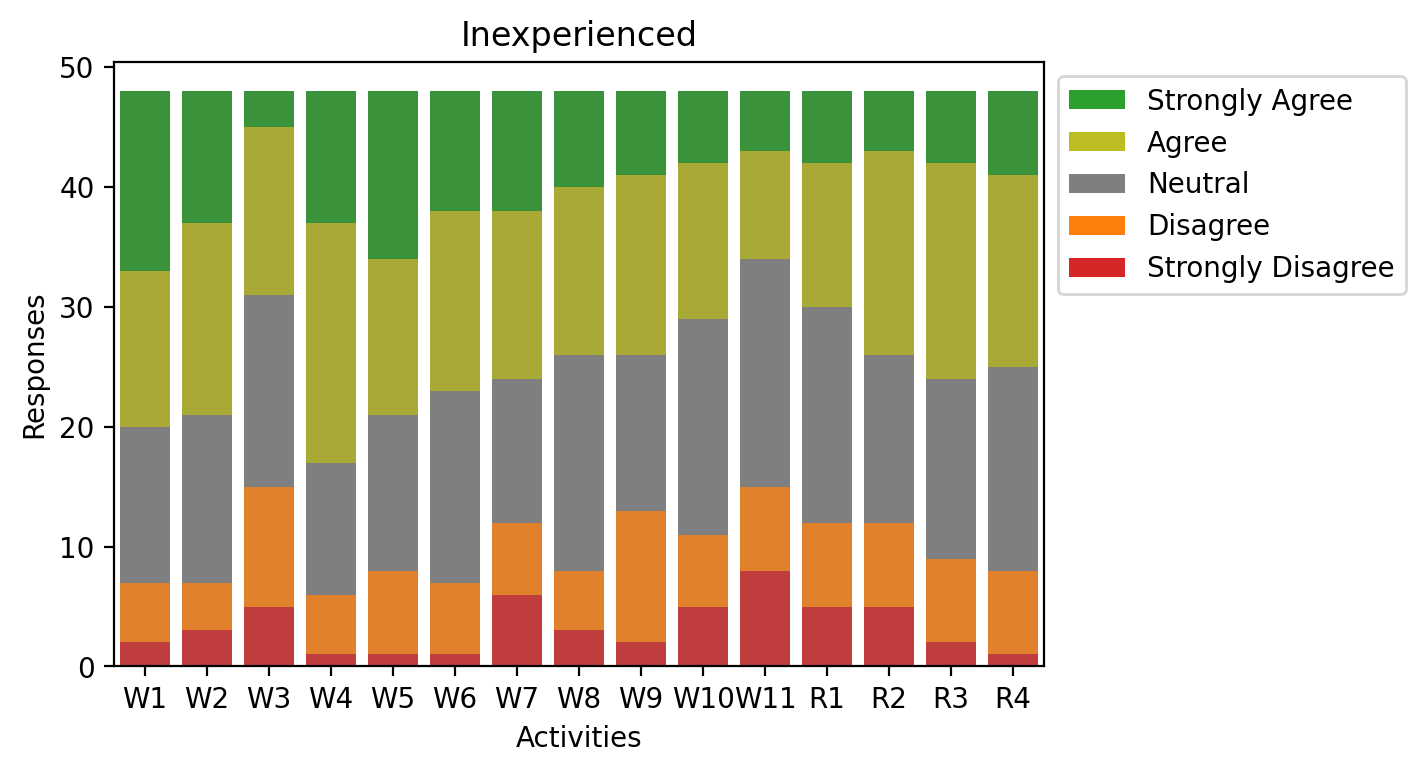

In [15]:
plt.figure(dpi=200)
ax = renderDCGraph(dcDataInexperienced)
ax.set(title="Inexperienced") 
plt.savefig('DC_Activities_Inexperienced.pdf', format='pdf', bbox_inches='tight')

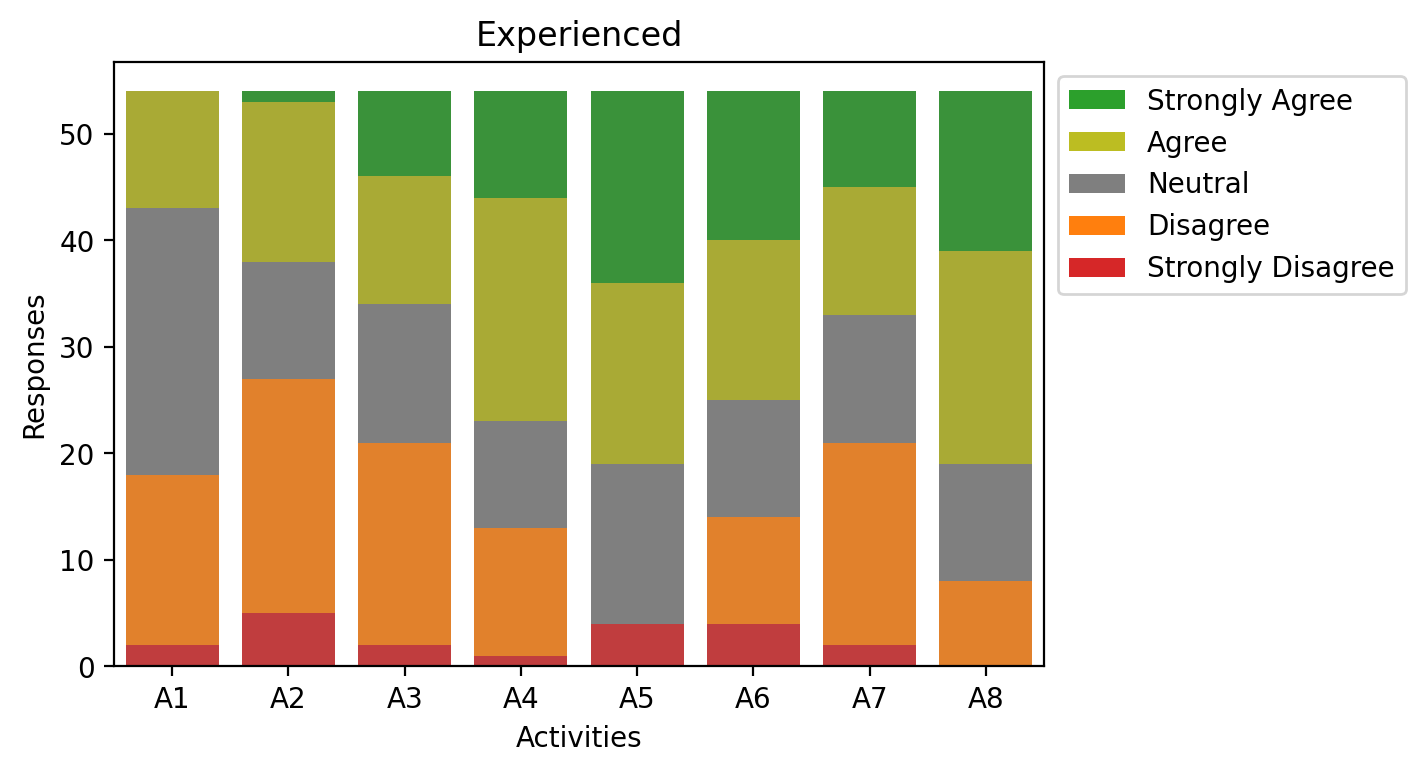

In [16]:
plt.figure(dpi=200)
ax = renderGraph(dataExperienced)
ax.set(title="Experienced")
plt.savefig('D_Activities_Experienced.pdf', format='pdf', bbox_inches='tight')

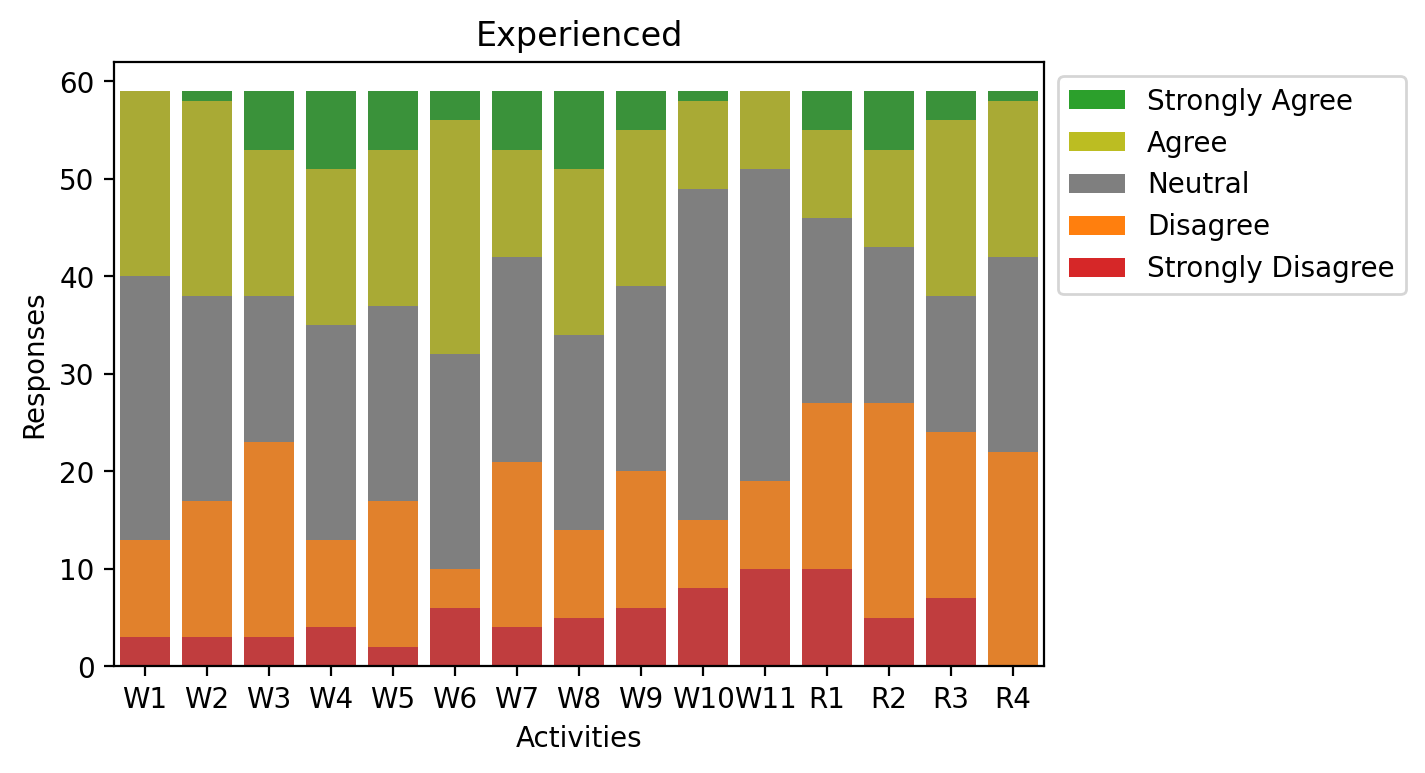

In [17]:
plt.figure(dpi=200)
ax = renderDCGraph(dcDataExperienced)
ax.set(title="Experienced")
plt.savefig('DC_Activities_Experienced.pdf', format='pdf', bbox_inches='tight')

In [18]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene
import numpy as np

def runTtest(paramToCompare, axis=0, equal_var=False, nan_policy='propagate'):
    datasetInexperienced = dataInexperienced[(dataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dataExperienced[(dataExperienced['params'] == paramToCompare)]

    return ttest_ind(datasetInexperienced['value'], datasetExperienced['value'], axis, equal_var, nan_policy) 

def runWmw(paramToCompare, use_continuity=True, alternative=None):
    datasetInexperienced = dataInexperienced[(dataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dataExperienced[(dataExperienced['params'] == paramToCompare)]
    
    return mannwhitneyu(datasetInexperienced['value'], datasetExperienced['value'], use_continuity, alternative)

def runDcWmw(paramToCompare, use_continuity=True, alternative=None):
    datasetInexperienced = dcDataInexperienced[(dcDataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dcDataExperienced[(dcDataExperienced['params'] == paramToCompare)]
    
    return mannwhitneyu(datasetInexperienced['value'], datasetExperienced['value'], use_continuity, alternative)

def runMean(paramToCompare):
    datasetInexperienced = dataInexperienced[(dataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dataExperienced[(dataExperienced['params'] == paramToCompare)]
    
    return np.mean(datasetInexperienced['value']),np.mean(datasetExperienced['value'])

def runDcMean(paramToCompare):
    datasetInexperienced = dcDataInexperienced[(dcDataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dcDataExperienced[(dcDataExperienced['params'] == paramToCompare)]
    
    return np.mean(datasetInexperienced['value']),np.mean(datasetExperienced['value'])

def runStd(paramToCompare):
    datasetInexperienced = dataInexperienced[(dataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dataExperienced[(dataExperienced['params'] == paramToCompare)]

    return np.std(datasetInexperienced['value']),np.std(datasetExperienced['value'])

def runDcStd(paramToCompare):
    datasetInexperienced = dcDataInexperienced[(dcDataInexperienced['params'] == paramToCompare)]
    datasetExperienced = dcDataExperienced[(dcDataExperienced['params'] == paramToCompare)]

    return np.std(datasetInexperienced['value']),np.std(datasetExperienced['value'])
    

In [19]:
mask = []

def isNaN(num):
    return num != num

for index, row in data.iterrows():
    if (isinstance(row.value, int) | isinstance(row.value, float) | is_numeric_dtype(row.value)) and not isNaN(row.value):
        mask.append(True)
    else:
        mask.append(False)
    
numberColumns = data[mask].params.unique()

inexpr_mean = []
inexpr_std = []
expr_mean = []
expr_std = []
u = []
twosided_pvalues = []
less_pvalues = []
greater_pvalues = []
for param in numberColumns:
    mean = runMean(param)
    std = runStd(param)
    twosided_res = runWmw(param, alternative="two-sided")
    less_res = runWmw(param, alternative="less")
    greater_res = runWmw(param, alternative="greater")
    twosided_pvalues.append(format(twosided_res.pvalue,'f'))
    less_pvalues.append(format(less_res.pvalue,'f'))
    greater_pvalues.append(format(greater_res.pvalue,'f'))
    u.append(twosided_res.statistic)
    inexpr_mean.append(mean[0])
    inexpr_std.append(std[0])
    expr_mean.append(mean[1])
    expr_std.append(std[1])

ttestResults = pd.DataFrame ({
    'params': numberColumns,
    "inexpr_mean": inexpr_mean,
    "inexpr_std": inexpr_std,
    "expr_mean": expr_mean,
    "expr_std": expr_std,
    "u" : u, 
    "twosided_pvalues" : twosided_pvalues, 
    "less_pvalues" : less_pvalues,
    "greater_pvalues" : greater_pvalues 
})
ttestResults

,params,inexpr_mean,inexpr_std,expr_mean,expr_std,u,twosided_pvalues,less_pvalues,greater_pvalues
0,... that had a Dockerfile?,2.400000,1.023568,4.888889,0.916246,129.0,0.000000,0.000000,1.000000
1,... that had a docker-compose.yml file?,1.733846,1.201829,3.814815,1.611005,560.5,0.000000,0.000000,1.000000
2,... where you have used Dockerfiles created by others (colleagues or third parties)?,2.241538,1.161550,4.555556,1.369870,374.0,0.000000,0.000000,1.000000
3,... where you have used docker-compose.yml files created by others (colleagues or third parties)?,1.576923,1.356553,3.611111,1.757699,668.5,0.000000,0.000000,1.000000
4,... where you created/updated a Dockerfile?,2.046154,0.835386,4.833333,0.897527,0.0,0.000000,0.000000,1.000000
5,... where you created/updated a docker-compose.yml file?,1.441538,1.100474,3.722222,1.725803,521.5,0.000000,0.000000,1.000000
6,"When I write a Dockerfile, I spend considerable time ... [reading Docker documentation.]",3.430769,1.037293,2.833333,0.787636,2371.0,0.000582,0.999715,0.000291
7,"When I write a Dockerfile, I spend considerable time ... [finding out what are the right Dockerfile commands that I need.]",3.692308,1.122128,2.722222,1.025899,2580.5,0.000005,0.999998,0.000003
8,"When I write a Dockerfile, I spend considerable time ... [finding out what parent image is the most suitable.]",3.676923,0.946373,3.092593,1.142909,2281.5,0.003590,0.998237,0.001795
9,"When I write a Dockerfile, I spend considerable time ... [finding out what are the dependencies of my system that must be added to the docker image.]",3.769231,1.063655,3.500000,1.084401,1999.0,0.176461,0.912654,0.088230


In [20]:
mask = []

def isNaN(num):
    return num != num

for index, row in dcData.iterrows():
    if (isinstance(row.value, int) | isinstance(row.value, float) | is_numeric_dtype(row.value)) and not isNaN(row.value):
        mask.append(True)
    else:
        mask.append(False)
    
numberColumns = dcData[mask].params.unique()

inexpr_mean = []
inexpr_std = []
expr_mean = []
expr_std = []
u = []
twosided_pvalues = []
less_pvalues = []
greater_pvalues = []
for param in numberColumns:
    mean = runDcMean(param)
    std = runDcStd(param)
    twosided_res = runDcWmw(param, alternative="two-sided")
    less_res = runDcWmw(param, alternative="less")
    greater_res = runDcWmw(param, alternative="greater")
    twosided_pvalues.append(format(twosided_res.pvalue,'f'))
    less_pvalues.append(format(less_res.pvalue,'f'))
    greater_pvalues.append(format(greater_res.pvalue,'f'))
    u.append(twosided_res.statistic)
    inexpr_mean.append(mean[0])
    inexpr_std.append(std[0])
    expr_mean.append(mean[1])
    expr_std.append(std[1])

ttestResults = pd.DataFrame ({
    'params': numberColumns,
    "inexpr_mean": inexpr_mean,
    "inexpr_std": inexpr_std,
    "expr_mean": expr_mean,
    "expr_std": expr_std,
    "u" : u, 
    "twosided_pvalues" : twosided_pvalues, 
    "less_pvalues" : less_pvalues,
    "greater_pvalues" : greater_pvalues 
})
ttestResults

,params,inexpr_mean,inexpr_std,expr_mean,expr_std,u,twosided_pvalues,less_pvalues,greater_pvalues
0,... that had a docker-compose.yml file?,1.577083,0.748676,4.169492,1.043991,57.0,0.000000,0.000000,1.000000
1,... where you have used docker-compose.yml files created by others (colleagues or third parties)?,1.364583,0.899882,3.898305,1.446151,240.0,0.000000,0.000000,1.000000
2,... where you created/updated a docker-compose.yml file?,1.264583,0.577888,4.118644,1.042889,0.0,0.000000,0.000000,1.000000
3,"When I write a docker-compose.yml file, I spend considerable time… [reading Docker documentation.]",3.708333,1.135751,3.101695,0.729405,1905.5,0.001353,0.999339,0.000676
4,"When I write a docker-compose.yml file, I spend considerable time… [finding out what are the keys that I need.]",3.583333,1.114924,3.033898,0.919950,1841.0,0.005586,0.997263,0.002793
5,"When I write a docker-compose.yml file, I spend considerable time… [finding out what images are available.]",3.000000,1.080123,3.016949,1.096860,1430.5,0.927655,0.538748,0.463827
6,"When I write a docker-compose.yml file, I spend considerable time… [trying to understand why the services are not working as intended.]",3.729167,0.994560,3.271186,1.054940,1770.5,0.021087,0.989637,0.010543
7,"When I write a docker-compose.yml file, I spend considerable time… [(re)starting the services to confirm that they are working as intended.]",3.666667,1.105542,3.118644,1.074902,1795.5,0.014223,0.993015,0.007112
8,"When I write a docker-compose.yml file, I spend considerable time… [configuring the properties of each service (e.g. port mapping, name, ...).]",3.562500,1.018705,3.305085,0.887851,1608.0,0.206799,0.897781,0.103399
9,"When I write a docker-compose.yml file, I spend considerable time… [configuring the dependencies between the services (e.g. depends_on).]",3.333333,1.280191,2.932203,1.117873,1702.0,0.065925,0.967509,0.032962


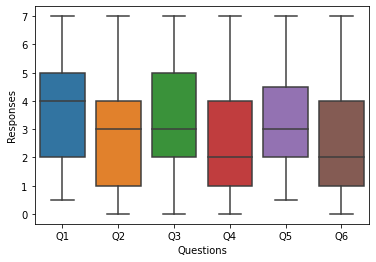

In [21]:
param1 = '... that had a Dockerfile?'
param2 = '... that had a docker-compose.yml file?'
param3 = '... where you have used Dockerfiles created by others (colleagues or third parties)?'
param4 = '... where you have used docker-compose.yml files created by others (colleagues or third parties)?'
param5 = '... where you created/updated a Dockerfile?'
param6 = '... where you created/updated a docker-compose.yml file?'

mask = ((data["params"] == param1) | (data["params"] == param2) | (data["params"] == param3) | (data["params"] == param4) \
        | (data["params"] == param5) | (data["params"] == param6))

ax = seaborn.boxplot(data=data[mask], x="params", y="value")

ax.set(xlabel='Questions', ylabel='Responses', xticklabels=["Q1", "Q2", "Q3", "Q4", "Q5", "Q6"])
plt.savefig(f'experience.pdf', format='pdf', bbox_inches='tight')

In [22]:
data[data["params"] == "Do you use any plugins/tools when developing Dockerfiles?"]["value"].value_counts()

No     93
Yes    26
Name: value, dtype: int64

In [23]:
print(data[data["params"] == "If so, which ones and how do they help you?"]["value"].unique())

[nan 'VSCode Docker extension' 'Syntax highlighters'
 'IDE, just syntax highlighting ' 'VScode: offers completion'
 "VSCode's syntax highlighting" 'IDE with Docker plugin.'
 'IntelliJIdea Docker / Docker Compose support (PHPStorm, RubyMine)'
 'I use IntelliJ that has plugins to develop Docker.' '-'
 'IntelliJ editor plugin'
 'A dockerfile linter, it helps to find bugs before the build failure 10 minutes later.'
 'vim with syntax highlighting, and the docker cli to check image sizes and things like that. Also some random bash tools to see how long each step takes.'
 '/' 'VS code plugins' 'Pycharm plugins for Dockerfile' 'A text editor'
 'Syntax highlighting, linting, auto complete (all in VSCode)'
 'https://www.fromlatest.io/#/'
 'pycharm or visual studio + docker + docker lint' 'Makefile'
 'Syntax highlighting' 'Visual Studio Code plugins mainly'
 'Visual Studio code docker extension' 'The vscode Docker Plugin'
 'Visual Studio Code for editing and command line to execute' 'buildkit'
 '

In [24]:
print(data[data["params"] == "What steps or strategies do you usually follow in order to diagnose and fix bugs in the creation of Dockerfiles?"]["value"].unique())

['deploy-test-debug-correct-redeploy-...'
 'Include runtime-checks, start and exec into it, rebuild, some-deployment issues involve investigating whether config ends up in the right place'
 'Performing traceability between the docker-compose file and source codes'
 'I try changing parameters 1 by 1 and retesting.  Also exec-ing into the container and inspecting logs.'
 'Truncate the Dockerfile and leave myself at bash and printf vars.'
 'first get to know the error or bug' nan
 'look at the logs , google the problems '
 'Read logs, get shell and execute commands '
 'docker run --rm -it image bash' 'Start a shell on the container'
 'Run the result, often with debug or logging' 'Debug'
 'Logs\r\nExecute a shell in the container\r\nMount current directory in container and work from there '
 'Develop the Dockerfile in increments' 'docker exec -it bash'
 'Reading the error messages and googling them' 'Play it by ear'
 'Check the log and figure out what is the problem, resolve and re run '
 

<ipython-input-25-36dc3b96f345>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(ylim=[1,5], xlim=[0,7], yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'], xlabel="Years of experience in Dockerfile development", ylabel="Answers", xticklabels=[">0","1","2","3","4","5","6","7"])


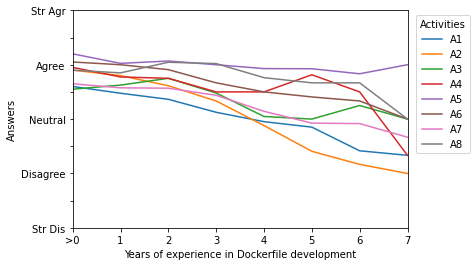

In [25]:
def skillIds(minSkill,maxSkill):
    experienceData = data[data["params"]=="... where you created/updated a Dockerfile?"]
    mask = (experienceData["value"] >= minSkill) & (experienceData["value"] <= maxSkill)
    selected = experienceData[mask]
    return selected.id

def paramByIds(param, ids):
    mask = (data["params"] == param) & (data["id"].isin(ids))
    return data[mask]
    

params = ['When I write a Dockerfile, I spend considerable time ... [reading Docker documentation.]',
          'When I write a Dockerfile, I spend considerable time ... [finding out what are the right Dockerfile commands that I need.]',
          'When I write a Dockerfile, I spend considerable time ... [finding out what parent image is the most suitable.]',
          'When I write a Dockerfile, I spend considerable time ... [finding out what are the dependencies of my system that must be added to the docker image.]',
          'When I write a Dockerfile, I spend considerable time ... [confirming if the resulting container is working as intended.]',
          'When I write a Dockerfile, I spend considerable time ... [trying to understand why the resulting container is not working as intended (e.g., running commands and tests on the container).]',
          'When I write a Dockerfile, I spend considerable time ... [finding out which commands are responsible for the container misbehaviour.]',
          'When I write a Dockerfile, I spend considerable time ... [rebuilding the image and re-running the container to confirm that it is working as intended.]']

linePlotParams = []
linePlotValue = []
linePlotExperience = []

for i in range(0,8):
    for j in range(0,15):
        ids = skillIds(j,j+1)
        responses = paramByIds(params[i],ids)
        for response in responses.iloc:
            linePlotParams.append(params[i])
            linePlotValue.append(response["value"])
            linePlotExperience.append(j)

linePlotData = pd.DataFrame(data={
    "params": linePlotParams,
    "value": linePlotValue,
    "experience": linePlotExperience
})

#plt.figure(dpi=200)
ax = seaborn.lineplot(x="experience", y ="value", hue="params", data=linePlotData, ci=None, marker="o", linestyle=(0, (1, 1)))
plt.legend(title='Activities', labels=['A1','A2','A3','A4','A5','A6','A7','A8'], bbox_to_anchor=(1.01, 1))
ax.set(ylim=[1,5], xlim=[0,7], yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'], xlabel="Years of experience in Dockerfile development", ylabel="Answers", xticklabels=[">0","1","2","3","4","5","6","7"])
plt.savefig(f'D_Per_Years.pdf', format='pdf', bbox_inches='tight')
pass


<ipython-input-26-5ba5894a9155>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(ylim=[1,5], xlim=[0,6], yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'], xlabel="Years of experience in docker-compose.ymls development", ylabel="Answers")


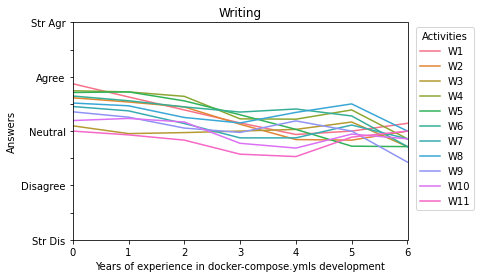

In [26]:
def skillIds(minSkill,maxSkill):
    experienceData = dcData[dcData["params"]=="... where you created/updated a docker-compose.yml file?"]
    mask = (experienceData["value"] >= minSkill) & (experienceData["value"] <= maxSkill)
    selected = experienceData[mask]
    return selected.id

def paramByIds(param, ids):
    mask = (dcData["params"] == param) & (dcData["id"].isin(ids))
    return dcData[mask]
    

params = ['When I write a docker-compose.yml file, I spend considerable time… [reading Docker documentation.]',
       'When I write a docker-compose.yml file, I spend considerable time… [finding out what are the keys that I need.]',
       'When I write a docker-compose.yml file, I spend considerable time… [finding out what images are available.]',
       'When I write a docker-compose.yml file, I spend considerable time… [trying to understand why the services are not working as intended.]',
       'When I write a docker-compose.yml file, I spend considerable time… [(re)starting the services to confirm that they are working as intended.]',
       'When I write a docker-compose.yml file, I spend considerable time… [configuring the properties of each service (e.g. port mapping, name, ...).]',
       'When I write a docker-compose.yml file, I spend considerable time… [configuring the dependencies between the services (e.g. depends_on).]',
       'When I write a docker-compose.yml file, I spend considerable time… [configuring volumes and how they are attached to the services.]',
       'When I write a docker-compose.yml file, I spend considerable time… [configuring networks and how they are connected to the services.]',
       'When I write a docker-compose.yml file, I spend considerable time… [configuring configs and how they are accessed by the services.]',
       'When I write a docker-compose.yml file, I spend considerable time… [configuring secrets and how they are accessed by the services.]']

linePlotParams = []
linePlotValue = []
linePlotExperience = []

# ids = skillIds(0,1)

for i in range(0,11):
    for j in range(0,7):
        ids = skillIds(j,j+1)
        responses = paramByIds(params[i],ids)
        for response in responses.iloc:
            linePlotParams.append(params[i])
            linePlotValue.append(response["value"])
            linePlotExperience.append(j)

linePlotData = pd.DataFrame(data={
    "params": linePlotParams,
    "value": linePlotValue,
    "experience": linePlotExperience
})

#plt.figure(dpi=200)
ax = seaborn.lineplot(x="experience", y ="value", hue="params", data=linePlotData, ci=None, marker="o", linestyle=(0, (1, 1)))
plt.legend(title='Activities', labels=['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11'], bbox_to_anchor=(1.01, 1))
ax.set(ylim=[1,5], xlim=[0,6], yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'], xlabel="Years of experience in docker-compose.ymls development", ylabel="Answers")
ax.set(title="Writing")
plt.savefig(f'DC_Per_Years_Writing.pdf', format='pdf', bbox_inches='tight')
pass


<ipython-input-27-f75a619765a1>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(ylim=[1,5], xlim=[0,6], xlabel="Years of experience in docker-compose.ymls development", ylabel="Answers", yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'])


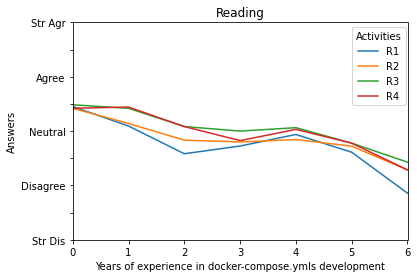

In [27]:
def skillIds(minSkill,maxSkill):
    experienceData = dcData[dcData["params"]=="... where you created/updated a docker-compose.yml file?"]
    mask = (experienceData["value"] >= minSkill) & (experienceData["value"] <= maxSkill)
    selected = experienceData[mask]
    return selected.id

def paramByIds(param, ids):
    mask = (dcData["params"] == param) & (dcData["id"].isin(ids))
    return dcData[mask]
    

params = ['When I read a docker-compose.yml file, I spend considerable time trying to understand … [ what the services are.]',
        'When I read a docker-compose.yml file, I spend considerable time trying to understand … [the dependencies between services (e.g. depends_on).]',
        'When I read a docker-compose.yml file, I spend considerable time trying to understand … [what volumes are used and how they are attached to the services.]',
        'When I read a docker-compose.yml file, I spend considerable time trying to understand … [what networks are used and how they are connected to the services.]']

linePlotParams = []
linePlotValue = []
linePlotExperience = []

for i in range(0,4):
    for j in range(0,7):
        ids = skillIds(j,j+1)
        responses = paramByIds(params[i],ids)
        for response in responses.iloc:
            linePlotParams.append(params[i])
            linePlotValue.append(response["value"])
            linePlotExperience.append(j)

linePlotData = pd.DataFrame(data={
    "params": linePlotParams,
    "value": linePlotValue,
    "experience": linePlotExperience
})

#plt.figure(dpi=200)
ax = seaborn.lineplot(x="experience", y ="value", hue="params", data=linePlotData, ci=None, marker="o", linestyle=(0, (1, 1)))
plt.legend(title='Activities', labels=['R1','R2','R3','R4'], bbox_to_anchor=(1.01, 1))
ax.set(ylim=[1,5], xlim=[0,6], xlabel="Years of experience in docker-compose.ymls development", ylabel="Answers", yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'])
ax.set(title="Reading")
plt.savefig(f'DC_Per_Years_Reading.pdf', format='pdf', bbox_inches='tight')
pass
